In [1]:
import os, sys
project_root_dir = os.path.join(os.getcwd(),'../..')
if project_root_dir not in sys.path:
    sys.path.append(project_root_dir)

from matplotlib import pyplot as plt
import numpy as np
from torch import nn
import torch
import config

from utils import show_abundance, plot_endmembers
from dataset import JasperRidge, Apex, Samson, NerveFat
from HySpecLab.metrics import rmse, sad
from scipy import io as sio
from utils import show_abundance, plot_endmembers

In [2]:
# dataset = JasperRidge(config.JasperRidge_PATH)
# result_path = os.path.join(config.RESULTS_PATH, 'jasperRidge')
# img_path = os.path.join(result_path, 'imgs')
# weights_path = os.path.join(result_path, 'clhu/weights')

# dataset = Apex(config.Apex_PATH)
# result_path = os.path.join(config.RESULTS_PATH, 'apex')
# img_path = os.path.join(result_path, 'imgs')
# weights_path = os.path.join(result_path, 'clhu/weights')

dataset = Samson(config.Samson_PATH)
result_path = os.path.join(config.RESULTS_PATH, 'samson')
img_path = os.path.join(result_path, 'imgs')
weights_path = os.path.join(result_path, 'clhu/weights')

# dataset = NerveFat(config.NerveFat_PATH)
# result_path = os.path.join(config.RESULTS_PATH, 'nerveFat')
# img_path = os.path.join(result_path, 'imgs')
# weights_path = os.path.join(result_path, 'clhu/weights')

# fig = show_abundance(dataset.abundance(), transpose=False)
# fig.savefig(os.path.join(img_path, 'A_GT.png'), dpi=300, bbox_inches='tight')


In [9]:
result_path

'/media/abian/Extreme SSD/Thesis/CLHU/review/samson'

In [3]:
def show_abundance(A, transpose=True, labels:list = None, figsize:tuple=(7,5)):
    '''
        Show abundance maps.

        Parameters
        ----------
            A : 3-D array, shape (n_rows, n_cols, n_endmembers)
                Abundance maps.
            labels : list, optional
                Labels for endmembers. Default is None.
            figsize : tuple, optional
                Figure size. Default is (7,5).
    '''
    _, _, n_endmembers = A.shape

    if labels is None:
        labels = list(map(lambda x: r'$m_{{{}}}$'.format(x), range(1, n_endmembers+1)))
        
    ticks_formatter = plt.FormatStrFormatter('%.1f')
    fig = plt.figure(figsize=(7,5))
    for i in range(n_endmembers):
        data = A[:,:,i].T if transpose else A[:,:,i]
        plt.subplot(3,4,i+1)
        plt.imshow(data, cmap='viridis')
        plt.axis('off')
        plt.title(labels[i], fontsize='x-large')
        cb = plt.colorbar(format=ticks_formatter, ticks=[data.min() + 1e-3, data.max() - 1e-3],
                         orientation='horizontal', fraction=0.1, pad=0.03)

    plt.tight_layout()
    return fig

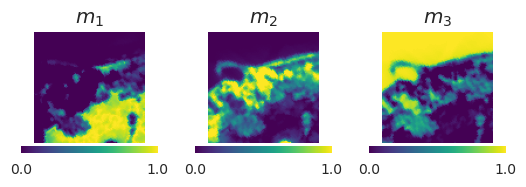

In [4]:
fig = show_abundance(dataset.abundance(), transpose=True)
# fig.savefig(os.path.join(img_path, 'methods/A_clhu.png'), dpi=300, bbox_inches='tight')
# fig.savefig(os.path.join(img_path, 'methods/A_gt.pdf'), bbox_inches='tight')

/media/abian/Extreme SSD/Thesis/CLHU/review/samson/clhu/weights/clhu.pth
/media/abian/Extreme SSD/Thesis/CLHU/review/samson/imgs/methods/A_clhu.png


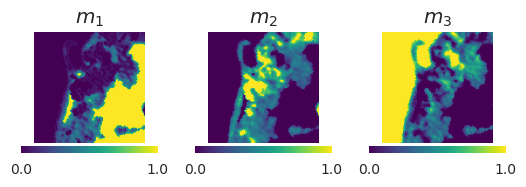

In [11]:
from HySpecLab.unmixing import ContrastiveUnmixing
from torch import softmax

print(os.path.join(weights_path, 'clhu.pth'))

# model = ContrastiveUnmixing(dataset.n_bands, 3)
model = ContrastiveUnmixing(dataset.n_bands, 3, sigma_sparsity=.5)

model.load_state_dict(torch.load(os.path.join(weights_path, 'clhu_vca.pth')))
model = model.eval()

with torch.no_grad():
    model(dataset.X)
    A_clhu = softmax(model.A.detach(), dim=1).cpu().numpy().reshape(dataset.n_row, dataset.n_col, -1)

fig = show_abundance(A_clhu, transpose=False)

print(os.path.join(img_path, 'methods/A_clhu.png'))
fig.savefig(os.path.join(img_path, 'methods/A_clhu.png'), dpi=300, bbox_inches='tight')
fig.savefig(os.path.join(img_path, 'methods/A_clhu.pdf'), bbox_inches='tight')

In [12]:
weights_path

'/media/abian/Extreme SSD/Thesis/CLHU/review/samson/clhu/weights'

In [13]:
model

ContrastiveUnmixing(
  (encoder): Sequential(
    (0): Sequential(
      (0): Linear(in_features=156, out_features=512, bias=True)
      (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0.5, inplace=False)
    )
    (1): Sequential(
      (0): Linear(in_features=512, out_features=128, bias=True)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0.5, inplace=False)
    )
    (2): Sequential(
      (0): Linear(in_features=128, out_features=32, bias=True)
      (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Identity()
    )
  )
  (sparse_gate): GaussianSparseness(in_features=32, sigma=0.50)
  (projection): Linear(in_features=32, out_features=156, bias=False)
)

In [14]:
os.path.join(weights_path, 'clhu.pth')

'/media/abian/Extreme SSD/Thesis/CLHU/review/samson/clhu/weights/clhu.pth'

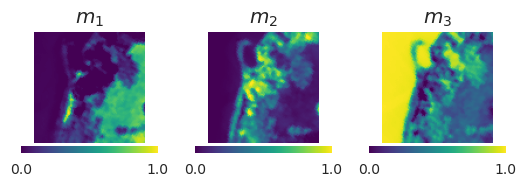

In [15]:
data = sio.loadmat(os.path.join(result_path, 'matlab/result/FCLS.mat'))
A_fcls = data['A_VCA'].T.reshape(dataset.n_col, dataset.n_row, -1)

fig = show_abundance(A_fcls, transpose=True)
# fig.savefig(os.path.join(img_path, 'methods/A_fcls.png'), dpi=300, bbox_inches='tight')
# fig.savefig(os.path.join(img_path, 'methods/A_fcls.pdf'), bbox_inches='tight')

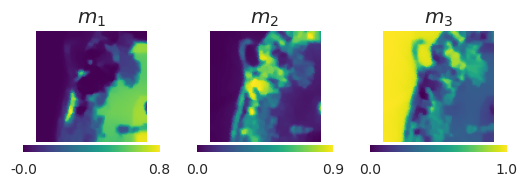

In [16]:
data = sio.loadmat(os.path.join(result_path, 'matlab/result/ELMM.mat'))
A_elmm = data['A_VCA'].T.reshape(dataset.n_col, dataset.n_row, -1)

fig = show_abundance(A_elmm, transpose=True)
# fig.savefig(os.path.join(img_path, 'methods/A_elmm.png'), dpi=300, bbox_inches='tight')
# fig.savefig(os.path.join(img_path, 'methods/A_elmm.pdf'), bbox_inches='tight')

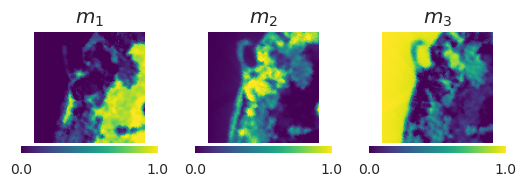

In [17]:
data = sio.loadmat(os.path.join(result_path, 'matlab/result/MESMA.mat'))
A_mesma = data['A_VCA'].T.reshape(dataset.n_col, dataset.n_row, -1)

fig = show_abundance(A_mesma, transpose=True)
# fig.savefig(os.path.join(img_path, 'methods/A_mesma.png'), dpi=300, bbox_inches='tight')
# fig.savefig(os.path.join(img_path, 'methods/A_mesma.pdf'), bbox_inches='tight')

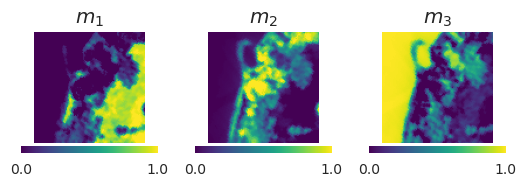

In [18]:
data = sio.loadmat(os.path.join(result_path, 'matlab/result/SocialSparseU.mat'))
A_fssu = data['A_VCA'].T.reshape(dataset.n_col, dataset.n_row, -1)

fig = show_abundance(A_fssu, transpose=True)
# fig.savefig(os.path.join(img_path, 'methods/A_fssu.png'), dpi=300, bbox_inches='tight')
# fig.savefig(os.path.join(img_path, 'methods/A_fssu.pdf'), bbox_inches='tight')

In [19]:
data = np.load(os.path.join(result_path, 'egu-net/result/A_Estimation/0.npy'))
A_egunet = data.reshape(dataset.n_col, dataset.n_row, -1)

fig = show_abundance(A_egunet, transpose=False)
# fig.savefig(os.path.join(img_path, 'methods/A_egunet.png'), dpi=300, bbox_inches='tight')
# fig.savefig(os.path.join(img_path, 'methods/A_egunet.pdf'), bbox_inches='tight')

FileNotFoundError: [Errno 2] No such file or directory: '/media/abian/Extreme SSD/Thesis/CLHU/review/samson/egu-net/result/A_Estimation/0.npy'

# Endmembers

In [36]:
M = dataset.endmembers() / dataset.endmembers().max()
from torch import sigmoid 
ebk = sigmoid(model.ebk.detach()).numpy()

# MESMA
data = sio.loadmat(os.path.join(result_path, 'matlab/result/MESMA.mat'))
M_mesma = data['M_VCA'].mean(axis=2).T

# FSSU
data = sio.loadmat(os.path.join(result_path, 'matlab/result/SocialSparseU.mat'))
M_fssu = data['M_VCA'].mean(axis=2).T

# FCLS - VCA
# data = sio.loadmat(os.path.join(result_path, 'matlab/result/FCLS.mat'))
# M_fcls = data['M_VCA'].mean(axis=2).T

# IDNet
data = sio.loadmat(os.path.join(result_path, 'idnet/result/vca/0.mat'))
M_idnet = data['Mn_est'].mean(axis=2).T

In [37]:
M_idnet.shape

(3, 156)

In [38]:
from matplotlib import pyplot as plt 
import numpy as np

def plot_endmembers(E: np.ndarray, wv:np.ndarray = None, labels:list = None, figsize:tuple = (7,5), subplot:bool=False, 
                    ticks_range:tuple=(0, 1), n_ticks:int=5, 
                    endmember_estimation:list = None, ee_labels:list = None):
    '''
        Plot endmembers.

        Parameters
        ----------
            E : 2-D array, shape (n_endmembers, n_bands)
                Endmembers.
            wv : 1-D array, optional, shape (n_bands)
                Wavelengths in nm. Default is None.
            labels : list, optional
                Labels for endmembers. Default is None.
            figsize : tuple, optional
                Figure size. Default is (7,5).
            ticks_range : tuple, optional
                Range of yticks. Default is (0, 1).
            n_ticks : int, optional
                Number of yticks. Default is 5.
            endmember_estimation : list, optional
                List of arrys which contains the endmembers estimation
                by different algorithms. Default is None. Max length: 3.
            ee_labels : list, optional
                Labels for the algorithms used in the endmembers estimation.
                Default is None.
    '''
    n_endmembers, n_bands = E.shape
    if labels is None:
        labels = list(map(lambda x: r'$m_{{{}}}$'.format(x), range(1, n_endmembers+1)))

    with plt.style.context(("seaborn-colorblind")):
        colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
        if subplot:
            fig, ax = plt.subplots(1, len(E), figsize=figsize)
        else:
            fig, ax = plt.subplots(1, 1, figsize=figsize)

        y_ticks = np.linspace(*ticks_range, n_ticks)
        x_ticks = np.linspace(1, n_bands, n_ticks, dtype=int)

        # check if ax is a array
        if subplot:
            for i in range(len(ax)):
                if endmember_estimation is not None:
                    ee = list(map(lambda x: x[i].reshape(1,-1), endmember_estimation))
                else:
                    ee = None
                plot_axis(ax[i], E[i].reshape(1,-1), labels[i], wv, x_ticks, y_ticks, ticks_range, 
                            color=colors[i], set_ylabel=True if i==0 else False, endmember_estimation=ee,
                            ee_labels=ee_labels)
        else:
            plot_axis(ax, E, labels, wv, x_ticks, y_ticks, ticks_range, endmember_estimation=endmember_estimation,
                      ee_labels=ee_labels)
    
        if subplot:
            handles = []
            labels = []

            for i in range(len(ax)):
                h, l = ax[i].get_legend_handles_labels()
                handles.extend(h)
                labels.extend(l)
        else:
            handles, labels = ax.get_legend_handles_labels()

        fig.legend(handles, labels, loc='upper center', ncol=6, fontsize='large', borderpad=-.25)
        fig.tight_layout(pad=(((n_endmembers-1)//6)+1)*2) # padding based on the endmembers number

    return fig

def plot_axis(ax, E, labels, wv, x_ticks, y_ticks, ticks_range, endmember_estimation=None, ee_labels=None, 
              color=None, set_ylabel=True):
    '''
        Parameters
        ----------
            ax : matplotlib.axes._subplots.AxesSubplot
                Axes object.   
            E : 2-D array, shape (n_endmembers, n_bands)
                Endmembers.
    '''
    ticks_formatter = plt.FormatStrFormatter('%.2f')
    n_bands = E.shape[1]

    if color and not(color is list):
        ax.plot(E.T, label=labels, color=color)
    else:
        ax.plot(E.T, label=labels)
    ax.set_xlabel('Bands', fontsize='x-large')
    ax.set_xticks(x_ticks)
    ax.set_xlim(0 - 1.5, n_bands + 1.5)
    if wv is None:
        ax.set_xlabel('Bands', fontsize='x-large')
    else:
        ax.set_xticklabels(wv[x_ticks-1])
        ax.set_xlabel('Wavelength (nm)', fontsize='x-large')

    ax.set_yticks(y_ticks)
    if set_ylabel:
        ax.set_ylabel('Reflectance', fontsize='x-large')           
        ax.yaxis.set_major_formatter(ticks_formatter) # set format in y ticks labels
    else:
        ax.set_yticklabels(['']*len(y_ticks))
    
    ax.set_ylim(ticks_range[0] - 0.025, ticks_range[1] + 0.025)
    ax.tick_params(axis='both', labelsize='large')

    if endmember_estimation is not None and ee_labels is not None:
        if color is None:
            color =  plt.rcParams['axes.prop_cycle'].by_key()['color']
        else:
            color = [color]
        ax = include_estimation(ax, color, endmember_estimation, ee_labels)

def include_estimation(ax, colors, endmember_estimation:list, labels:list):
    '''
        Include endmembers estimation in a plot.

        Parameters
        ----------
            ax : matplotlib.axes._subplots.AxesSubplot
                Axes object.
            colors : list
                List of colors for the endmembers.
            endmember_estimation : list, max length: 3
                List of arrys which contains the endmembers estimation
                by different algorithms.
            labels : list
                Labels for the algorithms used in the endmembers estimation.
    '''
    # styles = ['-', '--', ':', '-.']
    # styles = ['-', '--', ':', (0, (3, 5, 1, 5, 1, 5)))]
    linestyle = [
        ('solid', 'solid'),      # Same as (0, ()) or '-'
        ('dashed', 'dashed'),    # Same as '--'
        ('dotted', 'dotted'),    # Same as (0, (1, 1)) or ':'
        ('densely dashdotdotted', (0, (3, 1, 1, 1, 1, 1)))
     ]

    n_endmembers, _ = endmember_estimation[0].shape
    for i, endmember in enumerate(endmember_estimation):
        for j in range(n_endmembers):
            ax.plot(endmember_estimation[i][j], linestyle=linestyle[i+1][1], color=colors[j])
            # ax.plot(endmember_estimation[i][j], styles[i+1], color=colors[j])

    _ax = ax.twinx()
    for ss, sty in enumerate(labels):
        # _ax.plot(np.NaN, np.NaN, ls=styles[ss],
        _ax.plot(np.NaN, np.NaN, ls=linestyle[ss][1],
                label=labels[ss], c='black')
    _ax.get_yaxis().set_visible(False)
    _ax.legend(loc='upper left', fontsize='large')

    return _ax

In [39]:
m_ee = sio.loadmat(os.path.join(result_path, 'matlab/endmember_estimation.mat'))
M_vca = m_ee['VCA']

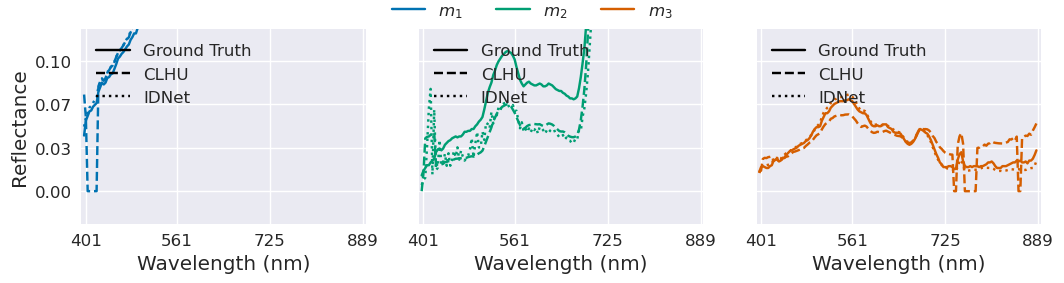

In [47]:
# for 4 endmembers, figsize=(15,3); for 3 endmembers, figsize=(11,3)
fig = plot_endmembers(dataset.E, np.array(dataset.wv), subplot=True, figsize=(11,3), n_ticks=4, ticks_range=(0, 1),
                endmember_estimation=[ebk, M_idnet], ee_labels=["Ground Truth", "CLHU", "IDNet"])
plt.show()

fig.savefig(os.path.join(img_path, 'methods/M.pdf'), bbox_inches='tight')

In [46]:
os.path.join(img_path, 'methods/M.pdf')

'/media/abian/Extreme SSD/Thesis/CLHU/review/samson/imgs/methods/M.pdf'

In [44]:
img_path

'/media/abian/Extreme SSD/Thesis/CLHU/review/samson/imgs'

In [25]:
img_path

'/media/abian/Extreme SSD/Thesis/CLHU/review/samson/imgs'

In [ ]:
print(dataset.E.shape)
fig = plot_endmembers(dataset.E, np.array(dataset.wv), ticks_range=(0,.1), subplot=True, figsize=(11,3), n_ticks=4, 
                endmember_estimation=[ebk, M_fssu], ee_labels=["Ground Truth", "CLHU", "FSSU"])
plt.show(fig)
fig.savefig(os.path.join(img_path, 'methods/M_scaled.pdf'), bbox_inches='tight')

In [ ]:
os.path.join(img_path, 'methods/M_scaled.pdf')

In [ ]:
plot_endmembers(dataset.E, np.array(dataset.wv), endmember_estimation=[ebk], ee_labels=["Ground Truth", 'CLHU'])
plt.show()